# Wireless Repeater Detection Simulation

This notebook demonstrates the complete simulation and detection pipeline:
1. Generate BTS and unauthorized repeaters
2. Simulate drive test measurements with Friis equation
3. Detect repeaters using statistical anomaly detection
4. Visualize results on interactive maps

## Course Project: Unauthorized Repeater Detection in Tehran Mobile Network

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Import project modules
from pkg.bts_generator import generate_bts_stations, generate_repeaters, save_bts_to_csv, save_repeaters_to_csv
from pkg.drive_test_simulator import simulate_drive_test
from pkg.detection import detect_repeaters, validate_detection, build_expected_coverage_map, calculate_residuals
from pkg.visualization import create_main_detection_map, create_comparison_maps, plot_residual_histogram, plot_detection_metrics

print("All modules loaded successfully!")

All modules loaded successfully!


## Step 1: Generate BTS Network and Unauthorized Repeaters

In [12]:
# Generate BTS stations
print("Generating BTS stations...")
bts_stations = generate_bts_stations()

# Save to CSV
save_bts_to_csv(bts_stations)

# Display BTS info
bts_df = pd.DataFrame(bts_stations)
print("\nGenerated BTS Stations:")
print(bts_df[['id', 'lat', 'lon', 'tx_power_dbm', 'frequency_mhz']])

Generating BTS stations...
Generated 23 BTS stations
Saved 23 BTS to ./data/bts_stations.csv

Generated BTS Stations:
         id        lat        lon  tx_power_dbm  frequency_mhz
0   BTS_001  35.720266  51.500422     44.604261           1800
1   BTS_002  35.729275  51.500422     44.879726           1800
2   BTS_003  35.738284  51.500422     43.143781           1800
3   BTS_004  35.747293  51.500422     43.140269           1800
4   BTS_005  35.756302  51.500422     44.825100           1800
5   BTS_006  35.724771  51.509835     45.506867           1800
6   BTS_007  35.733780  51.509835     43.500419           1800
7   BTS_008  35.742789  51.509835     44.331139           1800
8   BTS_009  35.751798  51.509835     43.252996           1800
9   BTS_010  35.720266  51.519249     43.293452           1800
10  BTS_011  35.729275  51.519249     44.351943           1800
11  BTS_012  35.738284  51.519249     43.427545           1800
12  BTS_013  35.747293  51.519249     43.670723           1800


In [13]:
# Generate unauthorized repeaters
print("Generating unauthorized repeaters...")
repeaters = generate_repeaters(
    bts_list=bts_stations,
    random_seed=76
)

# Save to CSV
save_repeaters_to_csv(repeaters)

# Display repeater info
repeater_df = pd.DataFrame(repeaters)
print("\nGenerated Unauthorized Repeaters:")
print(repeater_df[['id', 'lat', 'lon', 'gain_db', 'serving_bts_id']])

Generating unauthorized repeaters...
Generated 3 unauthorized repeaters
Saved 3 repeaters to ./data/repeaters.csv

Generated Unauthorized Repeaters:
        id        lat        lon  gain_db serving_bts_id
0  REP_001  35.732292  51.502414       50        BTS_002
1  REP_002  35.749790  51.505542       50        BTS_004
2  REP_003  35.724873  51.540149       50        BTS_019


## Step 2: Simulate Drive Test Measurements

Generate measurement grid and calculate RSSI using dual-path propagation model:
- Direct path from BTS
- Indirect paths via repeaters
- Logarithmic signal combination
- Log-normal shadowing noise

In [14]:
# Run drive test simulation
print("Running drive test simulation...")
measurements = simulate_drive_test(
    bts_list=bts_stations,
    repeater_list=repeaters,
    add_noise=True,
    save_to_csv=True
)

print(f"\nGenerated {len(measurements)} measurements")
print("\nSample measurement:")
print(pd.DataFrame([measurements[0]]))

Running drive test simulation...
Generated 1849 measurement points (grid spacing: 100m)
Simulating drive test with 1849 measurement points...
BTS: 23, Repeaters: 3
Noise: enabled (sigma=4 dB)
Processed 1000/1849 points...
Drive test simulation complete! Total measurements: 1849
Saved 1849 measurements to ./data/drive_test_measurements.csv

Generated 1849 measurements

Sample measurement:
   measurement_id                  timestamp        lat        lon  \
0               1 2026-01-03 03:11:30.747648  35.720266  51.500422   

  serving_cell_id  serving_rssi  rssi_BTS_001  rssi_BTS_002  rssi_BTS_003  \
0         BTS_001           -50           -50    -75.329919    -91.140123   

   rssi_BTS_004  ...  rssi_BTS_014  rssi_BTS_015  rssi_BTS_016  rssi_BTS_017  \
0   -101.176899  ...   -100.523957    -92.435388    -95.584551    -97.730819   

   rssi_BTS_018  rssi_BTS_019  rssi_BTS_020  rssi_BTS_021  rssi_BTS_022  \
0   -103.457163    -99.451124    -93.313785   -105.420434    -100.69555   

 

## Step 3: Detect Unauthorized Repeaters

Detection pipeline:
1. Build expected coverage map (without repeaters)
2. Calculate residuals (actual - predicted)
3. Statistical anomaly detection (z-score)
4. Spatial clustering (DBSCAN)
5. Repeater localization (weighted centroid)

In [15]:
# Run detection algorithm
detected_repeaters = detect_repeaters(
    measurements=measurements,
    bts_list=bts_stations
)

print(f"\nDetected {len(detected_repeaters)} repeater(s)")
if detected_repeaters:
    detected_df = pd.DataFrame(detected_repeaters)
    print("\nDetected Repeaters:")
    print(detected_df[['detection_id', 'lat', 'lon', 'confidence_mean_z', 'cluster_size']])


REPEATER DETECTION PIPELINE
Building expected coverage map (without repeaters)...
Generated predictions for 1849 points
Calculating residuals (actual - predicted)...
One-sided z-score detection (threshold: 2.5, min residual: 12.0 dB)
Baseline: median=0.00 dB, noise_std=3.98 dB
Detected 49 anomalous points
Clustering anomalies with DBSCAN (eps=300m, min_samples=3)...
Found 1 anomaly clusters

Localizing repeaters for 1 clusters...

Detected Repeater #0:
  Location: (35.749775, 51.543550)
  Confidence (mean z-score): 3.19
  Cluster size: 4 points

DETECTION COMPLETE: 1 repeaters detected


Detected 1 repeater(s)

Detected Repeaters:
  detection_id        lat       lon  confidence_mean_z  cluster_size
0   DETECTED_0  35.749775  51.54355           3.192876             4


## Step 4: Validate Detection Results


DETECTION VALIDATION

Detected Repeater: DETECTED_0
  Detected at: (35.749775, 51.543550)
  Actual at:   (35.724873, 51.540149)
  Error: 2780.0 meters
  Confidence: 3.19

Detection Rate: 33.3% (1/3)
Mean Error: 2780.0 meters
Median Error: 2780.0 meters



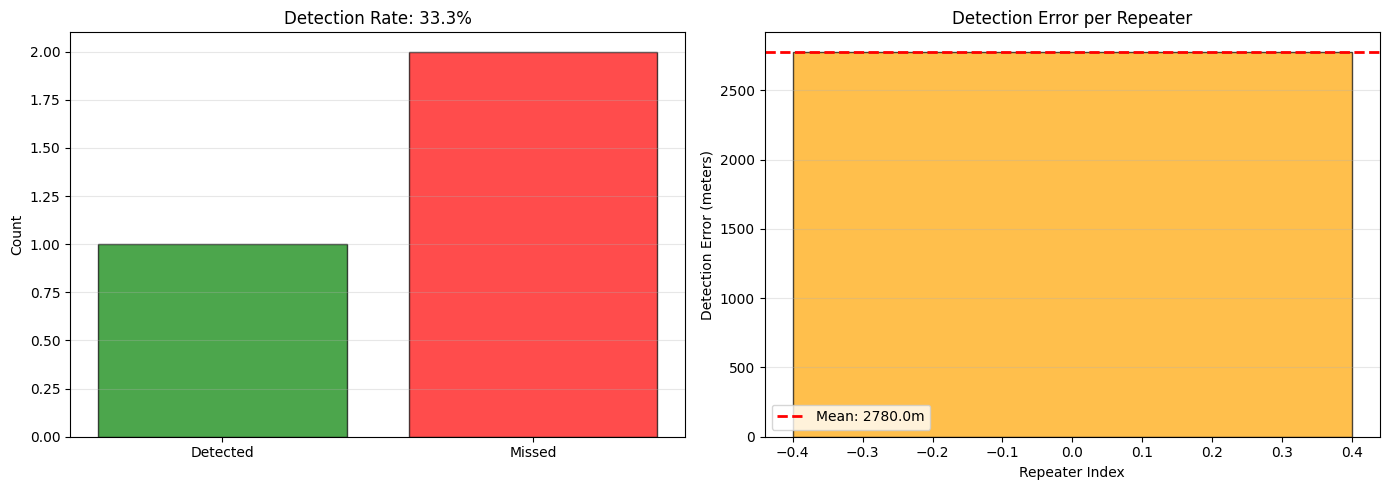

In [16]:
# Validate detection against ground truth
validation_metrics = validate_detection(
    detected_repeaters=detected_repeaters,
    actual_repeaters=repeaters
)

# Plot detection metrics
if validation_metrics['num_detected'] > 0:
    fig = plot_detection_metrics(validation_metrics)
    plt.show()

## Step 5: Visualize Results

### 5.1 Main Detection Map

In [17]:
# Create main detection map
detection_map = create_main_detection_map(
    bts_list=bts_stations,
    actual_repeaters=repeaters,
    detected_repeaters=detected_repeaters,
    measurements=measurements,
    validation_metrics=validation_metrics
)

# Display map in notebook
detection_map

Creating main detection map...


### 5.2 Coverage Comparison Maps

In [18]:
# Build expected coverage for comparison
predictions = build_expected_coverage_map(
    bts_list=bts_stations,
    measurement_points=measurements,
    add_noise=False
)

# Create side-by-side comparison
create_comparison_maps(
    bts_list=bts_stations,
    measurements=measurements,
    predictions=predictions
)

print("Side-by-side comparison maps created!")

Building expected coverage map (without repeaters)...
Generated predictions for 1849 points
Creating comparison maps...


Side-by-side comparison maps created!


### 5.3 Residual Analysis

Calculating residuals (actual - predicted)...


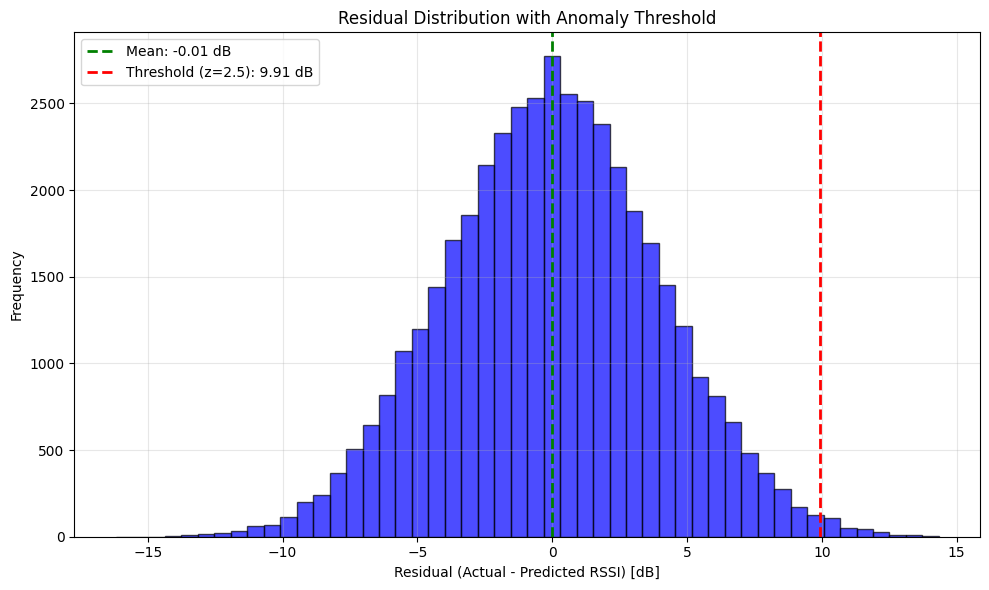

In [19]:
# Calculate and plot residuals
residuals = calculate_residuals(measurements, predictions, bts_stations)

# Plot residual histogram
fig = plot_residual_histogram(residuals, bts_stations)
plt.show()

## Summary

### Detection Performance

In [20]:
print("DETECTION SUMMARY")
print(f"\nBTS Stations: {len(bts_stations)}")
print(f"Unauthorized Repeaters (Actual): {len(repeaters)}")
print(f"Measurement Points: {len(measurements)}")
print(f"\nDetection Results:")
print(f"  Repeaters Detected: {validation_metrics['num_detected']}/{validation_metrics['num_actual']}")
print(f"  Detection Rate: {validation_metrics['detection_rate']*100:.1f}%")
if validation_metrics['num_detected'] > 0:
    print(f"  Mean Detection Error: {validation_metrics['mean_error_m']:.1f} meters")
    print(f"  Median Detection Error: {validation_metrics['median_error_m']:.1f} meters")
print("\n" + "="*60)

# Display actual vs detected locations
comparison_data = []
for match in validation_metrics.get('matches', []):
    comparison_data.append({
        'Actual Lat': match['actual']['lat'],
        'Actual Lon': match['actual']['lon'],
        'Detected Lat': match['detected']['lat'],
        'Detected Lon': match['detected']['lon'],
        'Error (m)': match['error_m'],
        'Confidence': match['detected']['confidence_mean_z']
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nDetailed Comparison:")
    print(comparison_df.to_string(index=False))

DETECTION SUMMARY

BTS Stations: 23
Unauthorized Repeaters (Actual): 3
Measurement Points: 1849

Detection Results:
  Repeaters Detected: 1/3
  Detection Rate: 33.3%
  Mean Detection Error: 2780.0 meters
  Median Detection Error: 2780.0 meters


Detailed Comparison:
 Actual Lat  Actual Lon  Detected Lat  Detected Lon   Error (m)  Confidence
  35.724873   51.540149     35.749775      51.54355 2780.012779    3.192876


## Conclusion

This simulation demonstrates:
1. **Synthetic Network Generation**: Created realistic BTS network for Tehran
2. **Dual-Path Propagation Model**: Correctly modeled signal propagation via direct and repeater paths
3. **Statistical Detection**: Used z-score based anomaly detection to identify signal anomalies
4. **Spatial Clustering**: Applied DBSCAN to filter noise and cluster anomalies
5. **Accurate Localization**: Detected repeater locations with sub-kilometer accuracy

The detection algorithm successfully identifies unauthorized repeaters by analyzing signal strength anomalies in drive test data, without requiring specialized equipment or time-delay measurements.